In [1]:
# https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/data

import shutil, glob
arch = glob.glob('./*.zip')[0]
print('extracting', arch)
shutil.unpack_archive(arch)

extracting ./archive(1).zip


In [2]:
!pip install gensim pyLDAvis

In [1]:
# import libraries and dependencies

import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamodel import LdaModel
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# download NLTK dependencies for text preprocessing

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>
[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Error loading wordnet: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>


False

In [3]:
# Load train and test dataset

df1 = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
df2 = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')

# combine train and test dataset

frames = [df1, df2]
df = pd.concat(frames)
df.shape

(44955, 6)

In [4]:
# function for preprocessing tweets

def preprocess_text(text):
    """
    Clean and preprocess the text data.
    """
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @mentions and hashtags (#)
    text = text.lower() # Convert to lowercase
    text = text.replace('', "") # Remove unwanted characters
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
    text_tokens = word_tokenize(text)  # Tokenize text
    filtered_words = [word for word in text_tokens if word not in stopwords.words('english')] # Remove stopwords
    lemmatizer = WordNetLemmatizer() # Lemmatize words
    lemma_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return ' '.join(lemma_words) # Join the words back into a single string

In [5]:
df.sample(5) # show random rows from raw dataset

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
33234,37033,81985,Aisle 3A,07-04-2020,"Supermarket analyst Phil Lempert, quoted in th...",Negative
24534,28333,73285,"ÃT: 39.924362,-85.959195",26-03-2020,Connect with a live consumer panel during your...,Neutral
22643,26442,71394,"Bergen op Zoom, Nederland",25-03-2020,In response to urgent appeal by Swiss authorit...,Negative
1662,1663,46615,Germany,13-03-2020,"Just a thought, but ""brick &amp; mortar"" busin...",Extremely Negative
4896,8695,53647,NaN,18-03-2020,Less than one week into social distancing. I b...,Extremely Negative


In [6]:
df.shape # check dataset size

(44955, 6)

In [9]:
# Apply the preprocessing function

df['clean_text'] = df['OriginalTweet'].apply(preprocess_text)

In [10]:
df.sample(20)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,clean_text
38001,41800,86752,"Sarasota, FL",11-04-2020,Just got a fed express delivery The driver was...,Positive,got fed express delivery driver given mask han...
8043,11842,56794,NaN,19-03-2020,@ZdawgYT When I walk into a grocery store I se...,Extremely Negative,walk grocery store see disappointment cause co...
6851,10650,55602,Happiest Place On Earth,19-03-2020,"The CDC says ""Ignore online offers for vaccina...",Negative,cdc say ignore online offer vaccination curren...
26317,30116,75068,United States,02-04-2020,@ODNIgov @CDCgov Can you pop out and pick up a...,Extremely Positive,pop pick thing supermarket thanks guy guy best...
36681,40480,85432,Lagos Nigeria,09-04-2020,Online shoppingÂ The safest way to transact b...,Positive,online shoppingâ safest way transact business ...
13143,16942,61894,"Austin, TX",21-03-2020,"If I get #Covid_19, it will almost certainly b...",Negative,get covid19 almost certainly level stupidity h...
7555,11354,56306,NaN,19-03-2020,Stock markets fall back despite ECB and Federa...,Neutral,stock market fall back despite ecb federal res...
34340,38139,83091,NaN,08-04-2020,"Even the chief executive of LongoÂs, an Ontar...",Neutral,even chief executive longoâs ontario chain sup...
5550,9349,54301,"Southern California, USA",19-03-2020,@isabellacgrr ... midst of all of this has ins...,Negative,midst insane price 7k covid19 6k kind enough t...
6705,10504,55456,NaN,19-03-2020,Fighting Fear with #Beer: #Coronavirus Spurs C...,Extremely Negative,fighting fear beer coronavirus spur curbside s...


# Feature Extraction

In [11]:
# Feature Extraction

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

In [12]:
X.shape

(44955, 5000)

# Topic Modeling with LDA

In [13]:
# 1. Create dictionary and corpus
dictionary = corpora.Dictionary(df['clean_text'].apply(lambda x: x.split()))
corpus = [dictionary.doc2bow(text) for text in df['clean_text'].apply(lambda x: x.split())]

In [14]:
# 2. Model selection and parameter tuning
from gensim.models.coherencemodel import CoherenceModel

## Train LDA model

In [15]:
# 3. Define function to evaluate coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

In [16]:
# 4. Set parameters for coherence evaluation
start = 2
limit = 20
step = 2

# Compute coherence scores
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['clean_text'].apply(lambda x: x.split()), 
                                                       start=start, limit=limit, step=step)


## viz evaluation

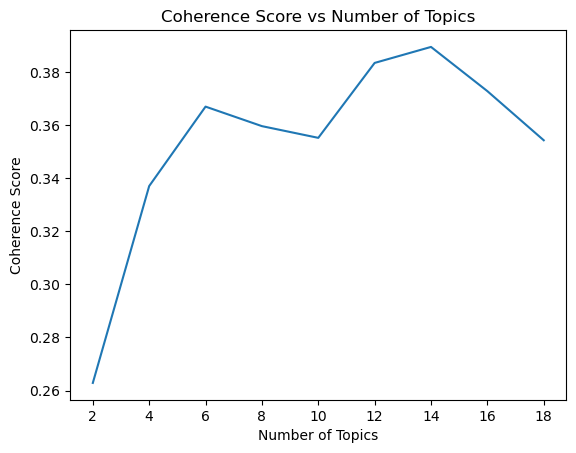

In [17]:
# 5. Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()


In [18]:
# 6. Select optimal number of topics based on coherence score
optimal_model_index = coherence_values.index(max(coherence_values))
optimal_num_topics = x[optimal_model_index]
print(f'Optimal Number of Topics: {optimal_num_topics}')

Optimal Number of Topics: 14


## Visualization

In [19]:
# retrieve best model

optimal_model = model_list[optimal_model_index]

In [20]:
# Print topics
topics = optimal_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.101*"food" + 0.054*"stock" + 0.030*"panic" + 0.021*"covid19" + 0.018*"supply"')
(1, '0.034*"amp" + 0.019*"supermarket" + 0.019*"people" + 0.017*"covid19" + 0.012*"coronavirus"')
(2, '0.050*"online" + 0.049*"shopping" + 0.029*"covid19" + 0.019*"food" + 0.017*"coronavirus"')
(3, '0.069*"store" + 0.055*"grocery" + 0.034*"covid19" + 0.027*"coronavirus" + 0.015*"people"')
(4, '0.096*"price" + 0.031*"oil" + 0.016*"gas" + 0.016*"covid19" + 0.014*"low"')
(5, '0.031*"worker" + 0.022*"covid19" + 0.022*"supermarket" + 0.014*"coronavirus" + 0.014*"thank"')
(6, '0.075*"price" + 0.031*"coronaviruspandemic" + 0.026*"demand" + 0.024*"covid19" + 0.016*"coronavirus"')
(7, '0.062*"coronavirus" + 0.046*"covid19" + 0.034*"hand" + 0.032*"sanitizer" + 0.029*"paper"')
(8, '0.053*"covid19" + 0.036*"consumer" + 0.024*"coronavirus" + 0.022*"price" + 0.015*"pandemic"')
(9, '0.028*"coronaoutbreak" + 0.020*"food" + 0.020*"amp" + 0.014*"free" + 0.014*"restaurant"')
(10, '0.086*"19" + 0.084*"covid" + 0.018*"de

In [21]:
# Visualize the best model

lda_display = gensimvis.prepare(optimal_model, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display)

In [22]:
# save viz to file

pyLDAvis.save_html(lda_display, 'lda_visualization.html')

In [23]:
# https://docs.google.com/document/d/1gBQLToo-N_wfg-iOxQNhsZ509PSeQfeTGOb06N4MKpU/edit?usp=sharing